# Objetivo
El objetivo de esta tarea es desarrollar de forma paulatina un sistema simple de detección de objetos en imágenes, basado en la teoría de campos receptivos de Hubel y Wiesel.

# Descripción
El reconocimiento de objetos es un problema altamente desafiante y que continúa
bajo investigación, debido a la alta variabilidad de patrones y las diferentes estrategias para
abordar este problema. En la actualidad, las Redes Neuronales Convolucionales han
presentado un mejor desempeño ante otros tipos de sistemas detectores, basándose en la
extracción de características por medio de filtros convolucionales. Estos tipos de filtros se
basan en el modelo de Hubel y Wiesel, quienes descubrieron que ciertas neuronas se excitan
cuando un patrón simple se sitúa en una zona particular de la retina, y que dichos estímulos
decrecen cuando el patrón se aleja.

Esta tarea tiene como finalidad implementar detectores simples de patrones,
diseñando filtros capaces de encontrar dichos objetos dentro de una imagen. Se partirá con
patrones simples dentro de una imagen binaria, hasta elementos más complejos como una
pieza de ajedrez en un tablero, o la detección de palabras en una sopa de letras.

# Implementación

## Importar librerías

In [1]:
import numpy as np
import math
import random
import scipy
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib.patches as patches

## A Detección de un patrón específico
En esta sección se desarrollará la detección de un patrón simple en una imagen pequeña. Se comprenderán los conceptos para luego generalizarlos.

* ## A.1 Convolución entre una imagen y un kernel

In [2]:
# computes the convolution between an image and a kernel of any size using zero padding
def convolution(image, kernel):
    output = np.zeros([image.shape[0],image.shape[1]])

    # number of rows and columns of input image
    rows = image.shape[0]
    cols = image.shape[1]

    # number of rows and columns of kernel
    kRows = kernel.shape[0]
    kCols = kernel.shape[1]

    # offset between central pixel of kernel and top left (beginning of for loop)
    offsetX = math.floor(kRows/2)
    offsetY = math.floor(kCols/2)

    # convolution
    for y in range(rows):
        for x in range(cols):
            sum = 0
            for kY in range(kRows):
                for kX in range(kCols):
                    posX = (x - offsetX) + kX
                    posY = (y - offsetY) + kY
                    if ((min(posX,posY) < 0) | (posX >= cols) | (posY >= rows)): # zero padding
                        pixel = 0.0
                    else:
                        pixel = image[posY,posX]
                    sum += pixel*kernel[kY,kX]
            output[y,x] = sum
    return output

* ## A.2 Generar detector de letra L

In [3]:
def makeL(rand):
    L = np.zeros((10,10))
    if rand:
        (y,x) = (random.randint(0,7),random.randint(0,8))
    else:
        (y,x) = (4,4)
    L[y:y+2,x] = 1
    L[y+2,x:x+2] = 1
    return L

In [4]:
def makeBalancedKernel():
    k = np.zeros((3,3))
    k[0:k.shape[0],0:k.shape[1]] = -1
    k[1,1] = 8
    return k

In [5]:
def makeDetectionFilter(image, kernel):
    out = convolution(image, kernel)
    out = np.flip(out, 0)
    out = np.flip(out, 1)
    return out

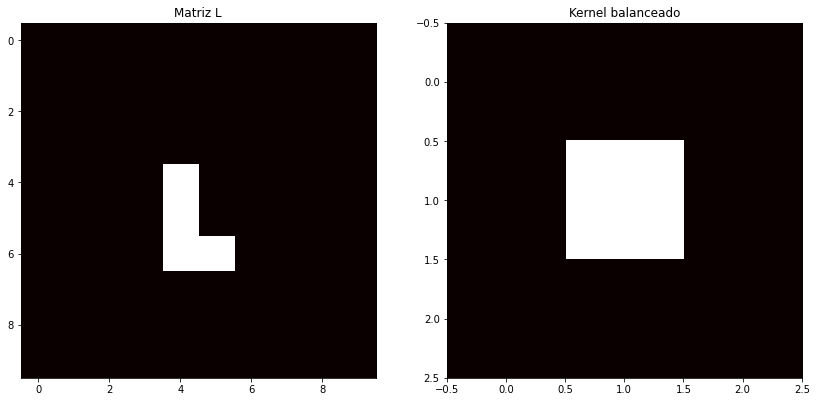

In [6]:
L = makeL(False)
k = makeBalancedKernel()
fig, axs = plt.subplots(1,2, figsize = (14,7))

axs[0].imshow(L, cmap = 'hot')
axs[0].set_title("Matriz L")
axs[1].imshow(k, cmap = 'hot')
axs[1].set_title("Kernel balanceado")
plt.savefig("matrizLyKernelBalanceado.png")
plt.show()


* ## A.3 Aplicar el filtro detector a la imagen y presentar mapas de calor

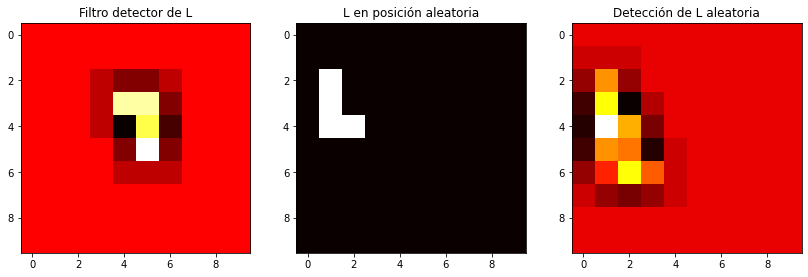

In [7]:
dFilter = makeDetectionFilter(L,k)
randomL = makeL(True)
detection = convolution(randomL, dFilter)

fig, axs = plt.subplots(1,3, figsize = (14,7))

axs[0].imshow(dFilter, cmap = 'hot')
axs[0].set_title("Filtro detector de L")
axs[1].imshow(randomL, cmap = 'hot')
axs[1].set_title("L en posición aleatoria")
axs[2].imshow(detection, cmap = 'hot')
axs[2].set_title("Detección de L aleatoria")
plt.savefig("filtroYDeteccion.png")
plt.show()

## B Detección de un patrón general
Ahora, se cargarán las diferentes imágenes entregadas y se detectarán objetos en las mismas. 

Para ello, debe trabajar con imágenes binarias y presentar los resultados sobre la imagen original. Muestre los resultados intermedios que se solicitan solo de un ejemplo en particular que usted desee.

* ## B.1 Lea una de las imágenes entregadas y conviératla a una imagen binaria

In [8]:
def makeBinary(image, threshold):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    out = np.zeros(image.shape)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            if image[y,x] >= threshold:
                out[y,x] = 1
            else:
                out[y,x] = 0
    return out

In [9]:
imgs = []
for image in os.listdir("imgs"):
    if image.endswith(((".jpg",".JPG"))):
        imgs.append(image)
imgs = np.sort(imgs)

In [10]:
imgIndex = -1
img = cv2.imread(f"imgs/{imgs[imgIndex]}", 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

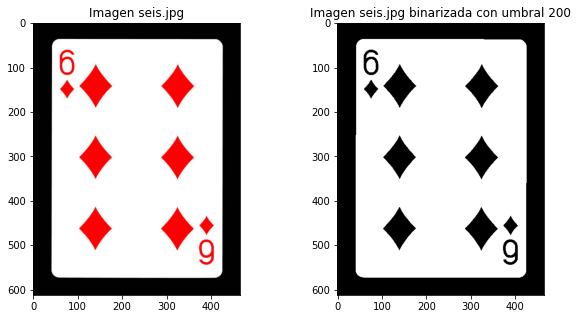

In [11]:
binary = makeBinary(img, 200) # hist(img.ravel(), 256, [0,256]) to choose threshold

fig, axs = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(10)

axs[0].imshow(img)
axs[0].set_title(f"Imagen {imgs[imgIndex]}")
axs[1].imshow(binary, cmap = 'gray')
axs[1].set_title(f"Imagen {imgs[imgIndex]} binarizada con umbral {200}")
# plt.savefig("binarizar.png")
plt.show()

* ## B.2 Escriba un algoritmo que permita recortar un patrón de una imagen

In [12]:
def extractPattern(image):
    # interactive window backend
    matplotlib.use('TkAgg')
    
    fig = plt.figure(figsize = (14,7))
    plt.imshow(image, cmap = 'gray')
    [P,Q] = np.array(plt.ginput(n = 2, timeout = 30), int)

    # original backend
    %matplotlib inline
    pattern = image[P[1]:Q[1], P[0]:Q[0]] 
    plt.imshow(pattern, cmap = 'gray')
    return pattern

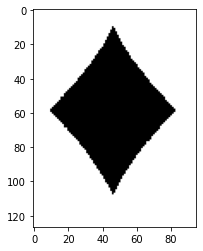

In [15]:
pattern = extractPattern(binary)

* ## B.3 Convolución entre el filtro detector y la imagen binaria

In [17]:
def getPatternFilter(pattern):
    conv = scipy.signal.fftconvolve(pattern, makeBalancedKernel(), mode='same')
#     conv = convolution(pattern, makeBalancedKernel())
    conv = np.flip(conv, 1)
    conv = np.flip(conv, 0)
    plt.imshow(conv, cmap = 'hot')
    plt.title("Filtro que detecta el patrón escogido")
#     plt.savefig("filtroDetector.png")
    plt.show()
    return conv

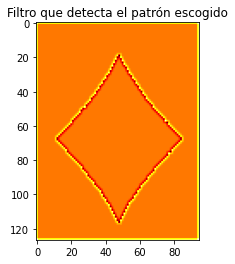

In [18]:
filt = getPatternFilter(pattern)

* ## B.3 Selección del umbral de detección


In [19]:
def chooseTr(conv):
    im = conv.ravel()
    # interactive window backend
    matplotlib.use('TkAgg')
    
    fig = plt.figure(figsize = (14,7))
    plt.plot(im)
    tr = np.array(plt.ginput(n = 1, timeout = 30), int)[0][1]
    
    # original backend
    %matplotlib inline
    
    plt.plot(im)
    plt.title("Valores detecciones con umbral")
    plt.hlines(tr, 0, len(conv.ravel()), 'red')
#     plt.savefig("umbral.png")
    return tr

In [20]:
det = scipy.signal.fftconvolve(binary, filt, mode='same')

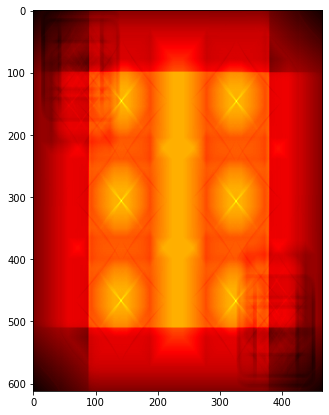

In [24]:
fig = plt.figure(figsize = (14,7))
plt.imshow(det, cmap = 'hot')

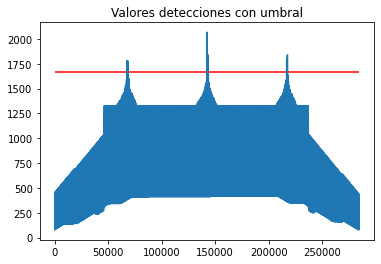

In [25]:
tr = chooseTr(det)

* ## B.5 Recuperar posiciones de los valroes que superan el umbral

In [15]:
def getMaxima(detection,thresh):
    maxima = []
    for y in range(detection.shape[0]):
        for x in range(detection.shape[1]):
            if detection[y,x] >= thresh:
                maxima.append({'coords':(x,y), 'value':detection[y,x]})
    return maxima

* ## B.6 Algoritmo de supresión de no máximos

In [16]:
def nonMaximumSupression(maxima):
    filtered = []
    print(f"Detecciones iniciales: {len(maxima)}")
    for i in range(len(maxima)):
        keep = True
        rangeX = (maxima[i]['coords'][0] - 0.05*maxima[i]['coords'][0],maxima[i]['coords'][0] + 0.05*maxima[i]['coords'][0])
        rangeY = (maxima[i]['coords'][1] - 0.05*maxima[i]['coords'][1],maxima[i]['coords'][1] + 0.05*maxima[i]['coords'][1])
        for j in range(len(maxima)):
            if (maxima[j]['coords'][0] in range(int(rangeX[0]),int(rangeX[1]))) & (maxima[j]['coords'][1] in range(int(rangeY[0]),int(rangeY[1]))):
                if maxima[j]['value'] > maxima[i]['value']:
                    keep = False
        if keep:
            filtered.append(maxima[i])
    print(f"Detecciones filtradas: {len(filtered)}")
    return filtered

* ## B.7 Detectar sobre las imágenes de entrada los patrones indicados

In [17]:
# draw boxes of detections in image
# pattern has the dimensions of the boxes and title the name of the original image
def drawBoxes(image, detections, pattern, title):
    fig, ax = plt.subplots(figsize = (14,7))
    ax.set_title(f'Imagen {title} con patrones detectados')
    ax.imshow(image)
    for det in detections:
        anchor = (det['coords'][0] - pattern.shape[1]/2, det['coords'][1] - pattern.shape[0]/2)
        ax.add_patch(patches.Rectangle(anchor, pattern.shape[1], pattern.shape[0], linewidth=1, edgecolor='green', facecolor='none'))
#     plt.savefig(f"det/{title}_patrones.png")

In [18]:
def patternDetection(img):
    # read selected image
    image = cv2.imread(f"imgs/{imgs[img]}", 1)
    # make it RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # make it binary
    binary = makeBinary(image, 200) # hist(img.ravel(), 256, [0,256]) to choose threshold
    # extract the target pattern
    pattern = extractPattern(binary)
    # compute the detection filter
    filt = getPatternFilter(pattern)
    # detect the pattern
    detection = scipy.signal.fftconvolve(binary, filt, mode='same')
#     detection = convolution(binary, filt)
    # choose detection threshold
    tr = chooseTr(detection)
    print(f"umbral: {tr}")
    # get maximum detections
    maxima = getMaxima(detection, tr)
    # filter non maximum detection
    filtered = nonMaximumSupression(maxima)
    # draw detections on original image
    drawBoxes(image, filtered, filt, imgs[img])

In [19]:
print(imgs)

['Cervantes.JPG' 'ChessBoard.JPG' 'Mancha.JPG' 'Sopa_Letras.JPG'
 'cartas.jpg' 'seis.jpg']


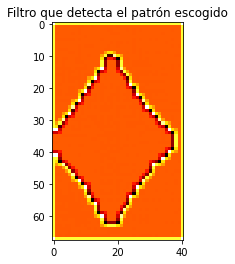

umbral: 753
Detecciones iniciales: 182
Detecciones filtradas: 46


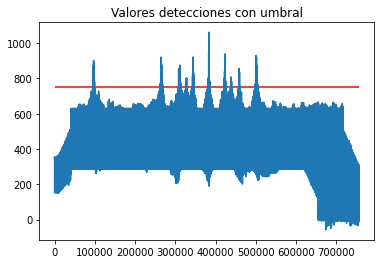

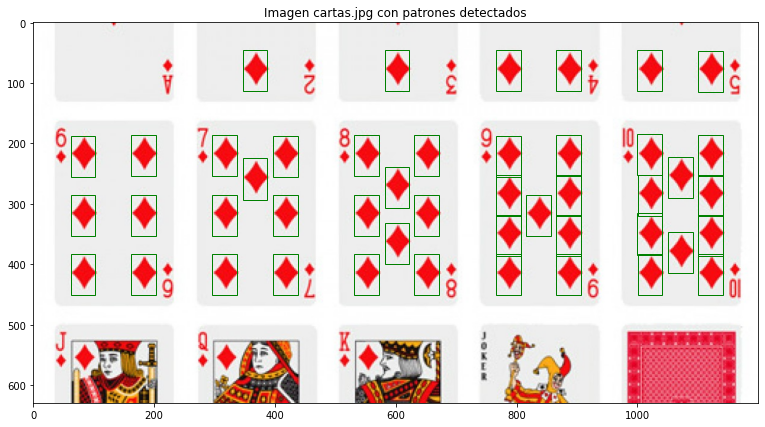

In [20]:
patternDetection(4)